Rows: 100
   id     subreddit                                               text  \
0   1  sexualhealth  People keep saying unalive instead of using th...   
1   2  sexualhealth  I am worried I might have an STI after unprote...   
2   3  sexualhealth  Some users replace words with emojis or strang...   
3   4  sexualhealth  I had sex for the first time and now I feel an...   
4   5  sexualhealth  Using terms like seggs instead of the real wor...   

       label  
0  algospeak  
1  algospeak  
2  algospeak  
3   explicit  
4  algospeak  

Label counts (training set candidates):
label
algospeak    52
explicit     21
neutral      20
Name: count, dtype: int64

=== Logistic Regression (TF-IDF) ===
              precision    recall  f1-score   support

   algospeak       0.82      1.00      0.90        14
    explicit       0.75      0.60      0.67         5
     neutral       0.67      0.40      0.50         5

    accuracy                           0.79        24
   macro avg       0.75 

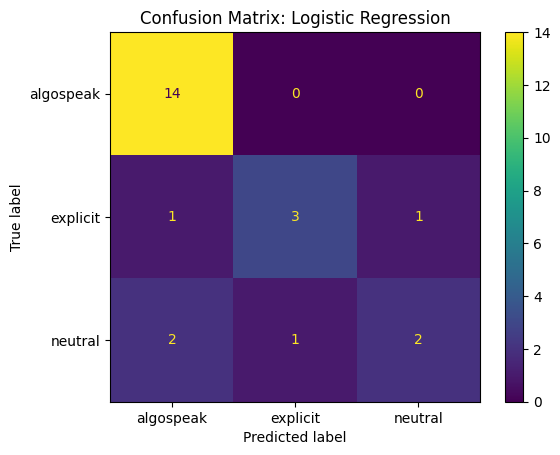


=== Naive Bayes (TF-IDF) ===
              precision    recall  f1-score   support

   algospeak       0.82      1.00      0.90        14
    explicit       0.75      0.60      0.67         5
     neutral       0.67      0.40      0.50         5

    accuracy                           0.79        24
   macro avg       0.75      0.67      0.69        24
weighted avg       0.78      0.79      0.77        24



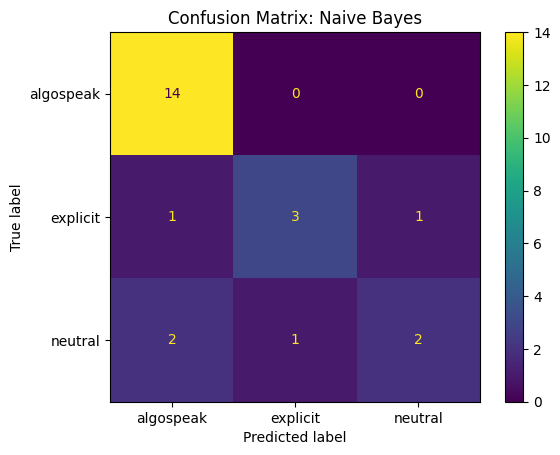

,text,true,pred_lr,pred_nb
0,is spotting after intercourse something to wor...,explicit,explicit,explicit
1,i keep seeing people say seggs instead of the ...,algospeak,algospeak,algospeak
2,can birth control fail even when used correctly,neutral,algospeak,algospeak
3,some phrases only make sense if you know the code,algospeak,algospeak,algospeak
4,i want to ask for advice but don t want the po...,algospeak,algospeak,algospeak
5,i had intimate contact and now i m worried abo...,explicit,explicit,explicit
6,certain emojis are enough for people to unders...,algospeak,algospeak,algospeak
7,does anyone know how long symptoms of chlamydi...,explicit,neutral,neutral
8,is it normal to feel soreness the next day,neutral,explicit,explicit
9,users invent new slang once the old words get ...,algospeak,algospeak,algospeak


In [1]:
# =========================
# Baseline ML for Algospeak (TF-IDF + Logistic Regression / Naive Bayes)
# Dataset: synthetic r/sexualhealth sample
# =========================

import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# 1) Load data from GitHub (RAW)
RAW_URL = "https://raw.githubusercontent.com/Mistermgallardo18/decoding-algospeak-ml-vs-llm/main/data/manual_reddit_comments.csv"
df = pd.read_csv(RAW_URL)

print("Rows:", len(df))
print(df.head())

# 2) Basic cleaning
def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)     # remove URLs
    s = re.sub(r"[^a-z0-9\s']", " ", s)         # keep letters/numbers/apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].apply(clean_text)

# 3) Define target labels
# Keep the 4 labels but optionally remove "uncertain" from training for cleaner evaluation
allowed_labels = ["algospeak", "explicit", "neutral"]  # exclude "uncertain" for baseline
df_model = df[df["label"].isin(allowed_labels)].copy()

print("\nLabel counts (training set candidates):")
print(df_model["label"].value_counts())

# 4) Train/test split
X = df_model["text_clean"].values
y = df_model["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 5) TF-IDF vectorisation (features)
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=2,
    max_df=0.95
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 6) Model A: Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_vec, y_train)
pred_lr = lr.predict(X_test_vec)

print("\n=== Logistic Regression (TF-IDF) ===")
print(classification_report(y_test, pred_lr))

cm_lr = confusion_matrix(y_test, pred_lr, labels=allowed_labels)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=allowed_labels)
disp_lr.plot()
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# 7) Model B: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
pred_nb = nb.predict(X_test_vec)

print("\n=== Naive Bayes (TF-IDF) ===")
print(classification_report(y_test, pred_nb))

cm_nb = confusion_matrix(y_test, pred_nb, labels=allowed_labels)
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=allowed_labels)
disp_nb.plot()
plt.title("Confusion Matrix: Naive Bayes")
plt.show()

# 8) Show example predictions (useful for screenshots)
examples = pd.DataFrame({
    "text": X_test[:12],
    "true": y_test[:12],
    "pred_lr": pred_lr[:12],
    "pred_nb": pred_nb[:12]
})
examples
